In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import six

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy.ndimage import morphology as mp

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, Concatenate, MaxPooling2D
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array

from tqdm import tqdm_notebook

from keras import Model
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.regularizers import l2
from keras.applications import VGG16

2024-03-22 20:42:20.134577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 20:42:20.627793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("GPU Available" if len(tf.config.list_physical_devices('GPU')) > 0 else "GPU Not Detected")

GPU Available


2024-03-22 20:42:21.560417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 20:42:21.577635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 20:42:21.578040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
from os import listdir

image_path = './data/images_cut/'
labels_path = './data/labels_cut/'

file_names = [filename for filename in listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)

train_image_path = [image_path + file_name for file_name in train_files]
train_mask_path = [labels_path + file_name for file_name in train_files]

eval_image_path = [image_path + file_name for file_name in val_files]
eval_mask_path = [labels_path + file_name for file_name in val_files]

In [4]:
img_size_ori = 101
img_size_target = (224, 840)
img_w_target = 224
img_h_target = 224

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)
    
def downsample(img):
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

In [5]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, images,image_dir,labels,label_dir ,batch_size=16, dim=(224,224,3) ,shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.image_dir = image_dir
        self.labels = labels
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            img = load_img(self.image_dir + self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            label = load_img(self.label_dir + self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)
            
        return np.array(batch_imgs,dtype = np.float32 ) ,np.array(batch_labels , dtype = np.float32 )

In [6]:
from os import listdir

train_imgs = listdir('./data/images_cut/')
train_masks = listdir('./data/labels_cut/')
train_imgs= sorted([ i for i in train_imgs ])
train_masks= sorted([ i for i in train_masks ])

print(len(train_imgs))
print(len(train_masks))

print(train_imgs[:3])
train_masks[:3]

train_df = pd.DataFrame({'image_path': train_image_path, 'mask_path': train_mask_path})

eval_df = pd.DataFrame({'image_path': eval_image_path, 'mask_path': eval_image_path})

val_img_dir =  './data/images_cut/'
val_mask_dir = './data/labels_cut/'
val_imgs = train_imgs[-25:]
val_masks = train_masks[-25:]
train_imgs = train_imgs[:-25]
train_masks = train_masks[:-25]

print(len(val_imgs))
print(len(val_masks))

100
100
['1008.png', '1009.png', '1016.png']
25
25


In [7]:
train_generator = DataGenerator(train_imgs,'./data/images_cut/',train_masks,'./data/labels_cut/',batch_size=36, dim=(224,224,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

2

/tmp/ipykernel_144249/188575041.py:54: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(mp.binary_erosion(label))
/tmp/ipykernel_144249/188575041.py:55: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


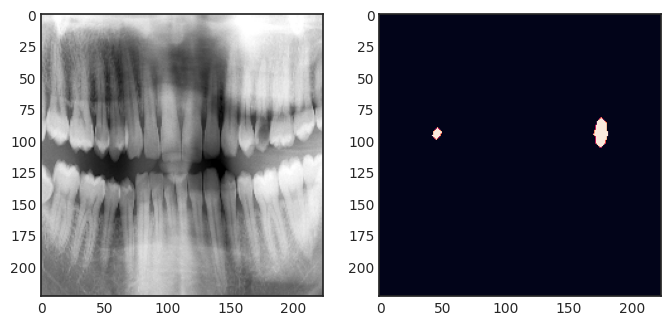

In [8]:
X,y = train_generator.__getitem__(1)
t = 26

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[t])
plt.subplot(122)
plt.imshow(np.reshape(y[t],(224,224)))

In [9]:
val_generator = DataGenerator(val_imgs,val_img_dir,val_masks,val_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

0

# Unet Model

In [10]:
def handle_block_names(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name

def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'1')(x)

        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)

        x = Activation('relu', name=relu_name+'1')(x)

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)

        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)

        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer

In [11]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [12]:
def build_unet(backbone, classes, last_block_filters, skip_layers,
               n_upsample_blocks=4, upsample_rates=(2,2,2,2),
               block_type='upsampling', activation='sigmoid',
               **kwargs):

    input = backbone.input
    x = backbone.output

    print("Layer", getLayerIndexByName(backbone, 'block3_conv1'))

    skip_layers = ([getLayerIndexByName(backbone, l) if isinstance(l, str) else l
                    for l in skip_layers])
                    
    for i in range(n_upsample_blocks):
        # check if there is a skip connection
        if i < len(skip_layers):
            skip = backbone.layers[skip_layers[i]].output
        else:
            skip = None

        up_size = (upsample_rates[i], upsample_rates[i])
        filters = last_block_filters * 2**(n_upsample_blocks-(i+1))

        x = Upsample2D_block(filters, i, upsample_rate=up_size, skip=skip, **kwargs)(x)

    if classes < 2:
        activation = 'sigmoid'

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    model = Model(input, x)

    return model

In [13]:
def UnetVgg(input_shape=(None, None, 3), classes=1, decoder_filters=16, decoder_block_type='upsampling',
                       encoder_weights=None, input_tensor=None, activation='sigmoid', **kwargs):

    backbone = VGG16(input_shape=input_shape,input_tensor=input_tensor,include_top=False)
    backbone.summary()

    skip_connections = list(['block1_conv2','block2_conv2','block3_conv3', 'block4_conv3', 'block5_conv3'])  # for resnet 34
    model = build_unet(backbone, classes, decoder_filters,
                       skip_connections, n_upsample_blocks=3, block_type=decoder_block_type,
                       activation=activation, **kwargs)
    model.name = 'u-resnet34'

    return model

In [14]:
def conv_block(inputs,filterCount):
    x = Conv2D(filterCount,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filterCount,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def decoder_block(inputs,skip_features,filter_count):
    
    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    print("x", x)
    print("skip_features", skip_features)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filter_count)
    return x

def unet_vgg16(input_shape):
    inputs = Input(input_shape)
    print(inputs.shape)
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor = inputs)
    #vgg16.summary()
    # the encoder 
    skip1 = vgg16.get_layer("block1_conv2").output
    print(skip1.shape)
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output
    # the center
    center = vgg16.get_layer("block5_conv3").output
    
    # the decoder 
    
    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)
    #output
    #conv1 = Conv2D(32,3,padding="same")(d4)
    #conv2 = Conv2D(16,3,padding="same")(conv1)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [15]:
# model = UnetVgg(input_shape=(img_w_target,img_h_target, 3))
model = unet_vgg16(input_shape=(224,224, 3))
model.summary()

(None, 224, 224, 3)


2024-03-22 20:42:22.602835: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 20:42:22.603052: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 20:42:22.603223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

(None, 224, 224, 64)
x <KerasTensor shape=(None, 28, 28, 512), dtype=float32, sparse=False, name=keras_tensor_19>
skip_features <KerasTensor shape=(None, 28, 28, 512), dtype=float32, sparse=False, name=keras_tensor_13>
x <KerasTensor shape=(None, 56, 56, 256), dtype=float32, sparse=False, name=keras_tensor_27>
skip_features <KerasTensor shape=(None, 56, 56, 256), dtype=float32, sparse=False, name=keras_tensor_9>
x <KerasTensor shape=(None, 112, 112, 128), dtype=float32, sparse=False, name=keras_tensor_35>
skip_features <KerasTensor shape=(None, 112, 112, 128), dtype=float32, sparse=False, name=keras_tensor_5>
x <KerasTensor shape=(None, 224, 224, 64), dtype=float32, sparse=False, name=keras_tensor_43>
skip_features <KerasTensor shape=(None, 224, 224, 64), dtype=float32, sparse=False, name=keras_tensor_2>


Model: "VGG16_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 25,862,337 (98.66 MB)

 Trainable params: 25,858,497 (98.64 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [16]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(tf.keras.layers.Flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
mc = ModelCheckpoint(mode='max', filepath='top.weights.h5', monitor='val_dice_coef',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=3, verbose=1)
callbacks = [mc, es]
model.metrics_names

['loss']

In [22]:
model_history = model.fit(train_generator, steps_per_epoch=train_steps,epochs=40,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

/tmp/ipykernel_144249/188575041.py:54: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(mp.binary_erosion(label))
/tmp/ipykernel_144249/188575041.py:55: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


Epoch 1/40


W0000 00:00:1711151252.942893  144334 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-03-22 20:47:33.530196: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 457.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-22 20:47:33.540987: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.67 = (f32[36,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,64,224,224]{3,2,1,0} %get-tuple-element.323, f32[64,64,3,3]{3,2,1,0} %transpose.414, f32[64]{0} %arg5.6), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", met

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_144249/1283256628.py", line 1, in <module>

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.67 = (f32[36,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,64,224,224]{3,2,1,0} %get-tuple-element.323, f32[64,64,3,3]{3,2,1,0} %transpose.414, f32[64]{0} %arg5.6), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="VGG16_U-Net_1/block1_conv2_1/convolution" source_file="/home/marcello/Repositories/MV2-Project/env/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 479199232 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_12001]

: 